In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import numpy as np
import random
from scipy.ndimage import rotate

In [3]:
data_path = '/content/drive/MyDrive/cat_dog_small'

In [4]:
categories = os.listdir(data_path)
categories

['cats_set', 'dogs_set']

In [5]:
labels = [i for i in range(len(categories))]
labels

[0, 1]

In [6]:
label_dict = dict(zip(categories, labels))
label_dict

{'cats_set': 0, 'dogs_set': 1}

In [7]:
img_size = 100
data = []
target = []

# Store images by category for balanced augmentation
data_by_category = {}
for category in categories:
    data_by_category[category] = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    image_names = os.listdir(folder_path)

    for img_name in image_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            target.append(label_dict[category])
            data_by_category[category].append(resized)

        except Exception as e:
            print('Exception:', e)

print(f"Original dataset loaded:")
for category in categories:
    count = len(data_by_category[category])
    print(f"{category}: {count} images")
print(f"Total original images: {len(data)}")

Original dataset loaded:
cats_set: 250 images
dogs_set: 250 images
Total original images: 500


In [8]:
# Image Augmentation Functions

def rotate_image(image, angle_range=(-15, 15)):
    """Rotate image by random angle"""
    angle = random.uniform(angle_range[0], angle_range[1])
    rotated = rotate(image, angle, reshape=False, cval=0)
    return rotated.astype(np.uint8)

def flip_horizontal(image):
    """Flip image horizontally"""
    return cv2.flip(image, 1)

def zoom_image(image, zoom_range=(0.8, 1.2)):
    """Apply random zoom to image"""
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])
    h, w = image.shape

    # Calculate new dimensions
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

    # Resize image
    resized = cv2.resize(image, (new_w, new_h))

    if zoom_factor > 1:  # Crop center
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        result = resized[start_h:start_h + h, start_w:start_w + w]
    else:  # Pad with zeros
        result = np.zeros((h, w), dtype=np.uint8)
        start_h = (h - new_h) // 2
        start_w = (w - new_w) // 2
        result[start_h:start_h + new_h, start_w:start_w + new_w] = resized

    return result

def shift_image(image, shift_range=(-10, 10)):
    """Apply random translation to image"""
    shift_x = random.randint(shift_range[0], shift_range[1])
    shift_y = random.randint(shift_range[0], shift_range[1])

    h, w = image.shape
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted = cv2.warpAffine(image, translation_matrix, (w, h), borderValue=0)

    return shifted

def adjust_brightness(image, brightness_range=(0.7, 1.3)):
    """Adjust image brightness"""
    brightness_factor = random.uniform(brightness_range[0], brightness_range[1])
    adjusted = image.astype(np.float32) * brightness_factor
    adjusted = np.clip(adjusted, 0, 255)
    return adjusted.astype(np.uint8)

# List of augmentation functions
augmentation_functions = [rotate_image, flip_horizontal, zoom_image, shift_image, adjust_brightness]
augmentation_names = ['rotation', 'horizontal_flip', 'zoom', 'shift', 'brightness']

In [9]:
# Data Augmentation Process

print("\n=== STARTING DATA AUGMENTATION ===")
print(f"Number of samples BEFORE augmentation: {len(data)}")

augmented_data = []
augmented_targets = []
augmentation_count = 0

for category in categories:
    category_images = data_by_category[category]
    category_label = label_dict[category]

    # Select 50% of images from this category for augmentation
    num_to_augment = len(category_images) // 2
    selected_images = random.sample(category_images, num_to_augment)

    print(f"\nAugmenting {num_to_augment} images from category '{category}'")

    for i, img in enumerate(selected_images):
        # Apply each augmentation technique
        for j, aug_func in enumerate(augmentation_functions):
            try:
                augmented_img = aug_func(img.copy())
                augmented_data.append(augmented_img)
                augmented_targets.append(category_label)
                augmentation_count += 1

                if (i * len(augmentation_functions) + j + 1) % 50 == 0:
                    print(f"  Processed {i * len(augmentation_functions) + j + 1} augmentations for {category}")

            except Exception as e:
                print(f"  Error in {augmentation_names[j]} augmentation: {e}")

print(f"\nTotal augmented images created: {augmentation_count}")

# Combine original and augmented data
combined_data = data + augmented_data
combined_targets = target + augmented_targets

print(f"\n=== AUGMENTATION SUMMARY ===")
print(f"Original images: {len(data)}")
print(f"Augmented images: {len(augmented_data)}")
print(f"Total images AFTER augmentation: {len(combined_data)}")
print(f"Augmentation ratio: {len(augmented_data)/len(data):.2f}x")


=== STARTING DATA AUGMENTATION ===
Number of samples BEFORE augmentation: 500

Augmenting 125 images from category 'cats_set'
  Processed 50 augmentations for cats_set
  Processed 100 augmentations for cats_set
  Processed 150 augmentations for cats_set
  Processed 200 augmentations for cats_set
  Processed 250 augmentations for cats_set
  Processed 300 augmentations for cats_set
  Processed 350 augmentations for cats_set
  Processed 400 augmentations for cats_set
  Processed 450 augmentations for cats_set
  Processed 500 augmentations for cats_set
  Processed 550 augmentations for cats_set
  Processed 600 augmentations for cats_set

Augmenting 125 images from category 'dogs_set'
  Processed 50 augmentations for dogs_set
  Processed 100 augmentations for dogs_set
  Processed 150 augmentations for dogs_set
  Processed 200 augmentations for dogs_set
  Processed 250 augmentations for dogs_set
  Processed 300 augmentations for dogs_set
  Processed 350 augmentations for dogs_set
  Processe

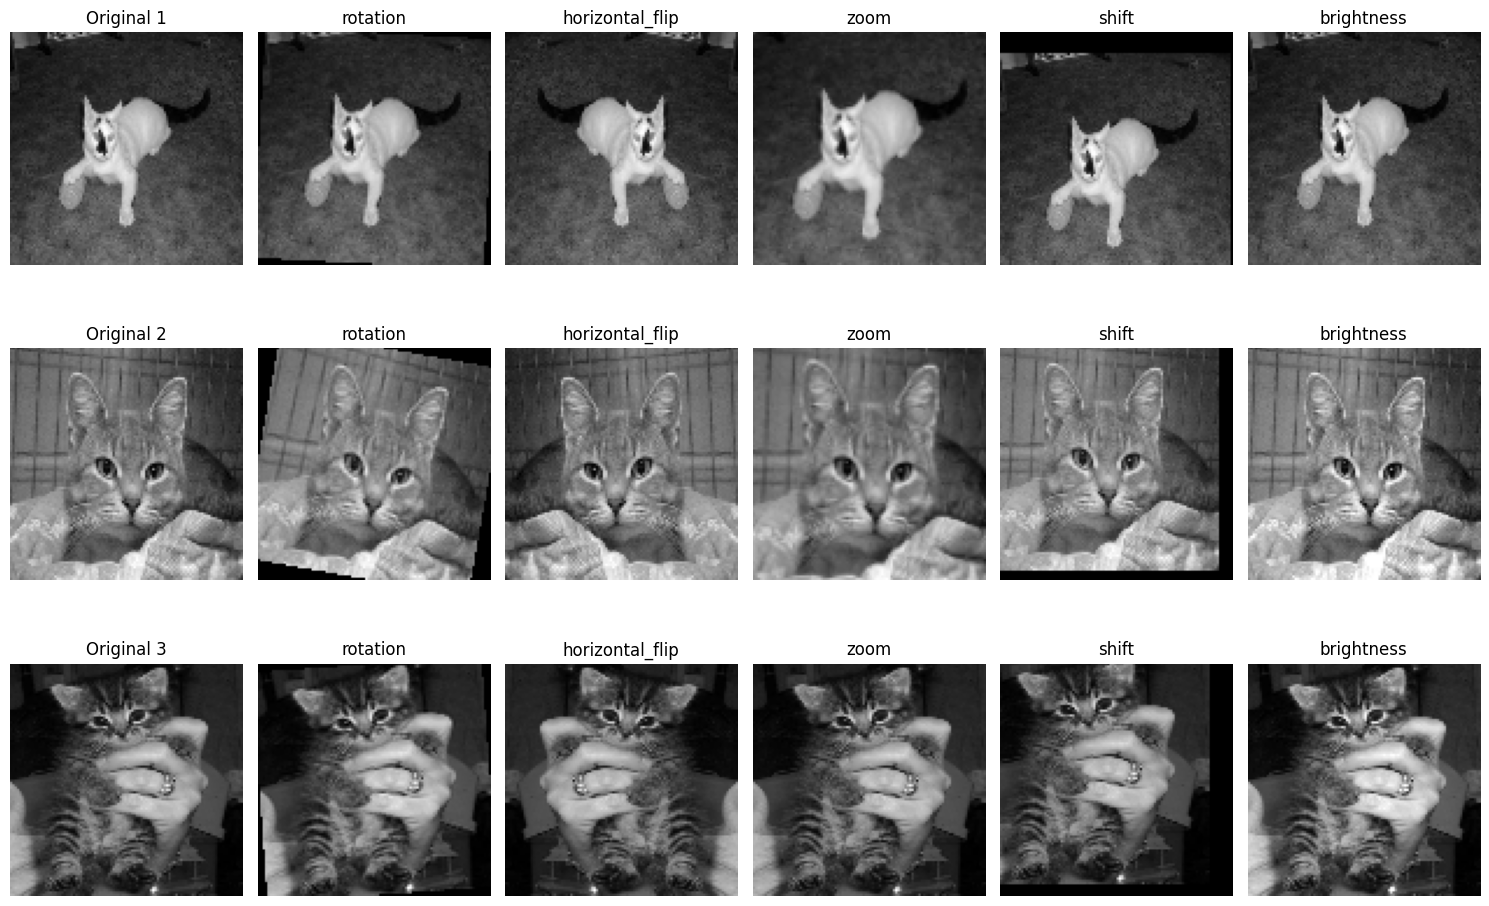

In [10]:
# Display some original and augmented samples
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Show original images
for i in range(3):
    plt.subplot(3, 6, i*6 + 1)
    plt.imshow(data[i], cmap="gray")
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Show augmented versions
    original_img = data[i]
    for j, (aug_func, aug_name) in enumerate(zip(augmentation_functions, augmentation_names)):
        plt.subplot(3, 6, i*6 + j + 2)
        aug_img = aug_func(original_img.copy())
        plt.imshow(aug_img, cmap="gray")
        plt.title(f"{aug_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Normalize and reshape the combined data
combined_data = np.array(combined_data) / 255.0
combined_data = np.reshape(combined_data, (combined_data.shape[0], img_size, img_size, 1))
combined_targets = np.array(combined_targets)

print(f"Final data shape: {combined_data.shape}")
print(f"Final targets shape: {combined_targets.shape}")

Final data shape: (1750, 100, 100, 1)
Final targets shape: (1750,)


In [12]:
from tensorflow.keras.utils import to_categorical
new_target = to_categorical(combined_targets)
print(f"One-hot encoded targets shape: {new_target.shape}")

One-hot encoded targets shape: (1750, 2)


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(combined_data, new_target, test_size=0.1, random_state=42)

print(f"Training set size: {x_train.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")
print(f"Shape of an image in train_data: {x_train[0].shape}")
print(f"Shape of an image in test_data: {x_test[0].shape}")

Training set size: 1575
Test set size: 175
Shape of an image in train_data: (100, 100, 1)
Shape of an image in test_data: (100, 100, 1)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(200, (3, 3), input_shape=combined_data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(100, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

print("Model architecture:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 200)    │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 98, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 47, 47, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     2,645,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,827,252 (10.79 MB)

 Trainable params: 2,827,252 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model compiled successfully!")

Model compiled successfully!


In [16]:
print("Starting model training...")
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, validation_split=0.2, batch_size=32)
print("Training completed!")

Starting model training...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.5263 - loss: 0.7204 - val_accuracy: 0.4571 - val_loss: 0.6937
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5114 - loss: 0.6919 - val_accuracy: 0.5600 - val_loss: 0.6877
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5985 - loss: 0.6547 - val_accuracy: 0.5943 - val_loss: 0.6336
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6977 - loss: 0.5623 - val_accuracy: 0.6286 - val_loss: 0.5913
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7681 - loss: 0.4923 - val_accuracy: 0.7086 - val_loss: 0.5976
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8573 - loss: 0.3503 - val_accuracy: 0.7886 - val_loss: 0.4894
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8818 - loss: 0.2715 - val_accuracy: 0.7143 - val_loss: 0.6697
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8962 - loss: 0.24

In [17]:
print("Model evaluation on test set:")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Model evaluation on test set:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8390 - loss: 0.6035
Test Loss: 0.6254
Test Accuracy: 0.8171


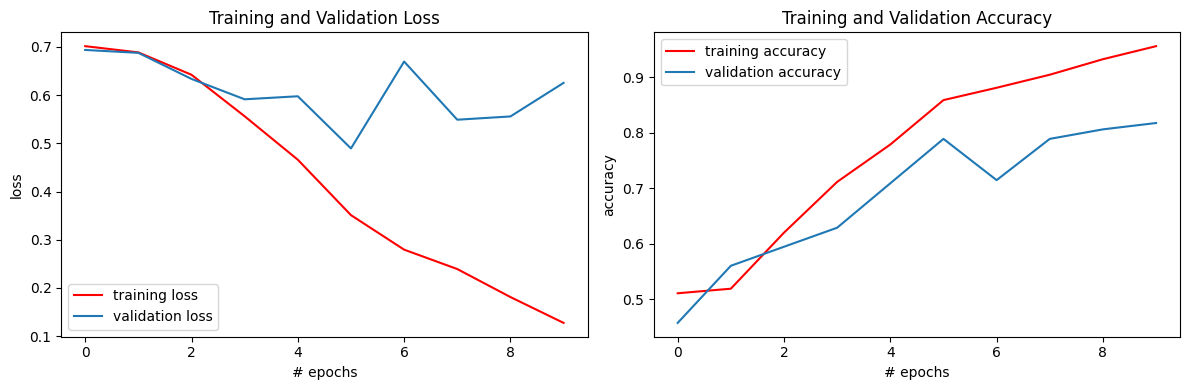

In [18]:
from matplotlib import pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [19]:
# Make predictions
y_predicted = model.predict(x_test)
y_predicted_classes = np.argmax(y_predicted, axis=1)
y_actual = np.argmax(y_test, axis=1)

print(f"Prediction probabilities shape: {y_predicted.shape}")
print(f"Predicted classes shape: {y_predicted_classes.shape}")
print(f"Actual classes shape: {y_actual.shape}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Prediction probabilities shape: (175, 2)
Predicted classes shape: (175,)
Actual classes shape: (175,)


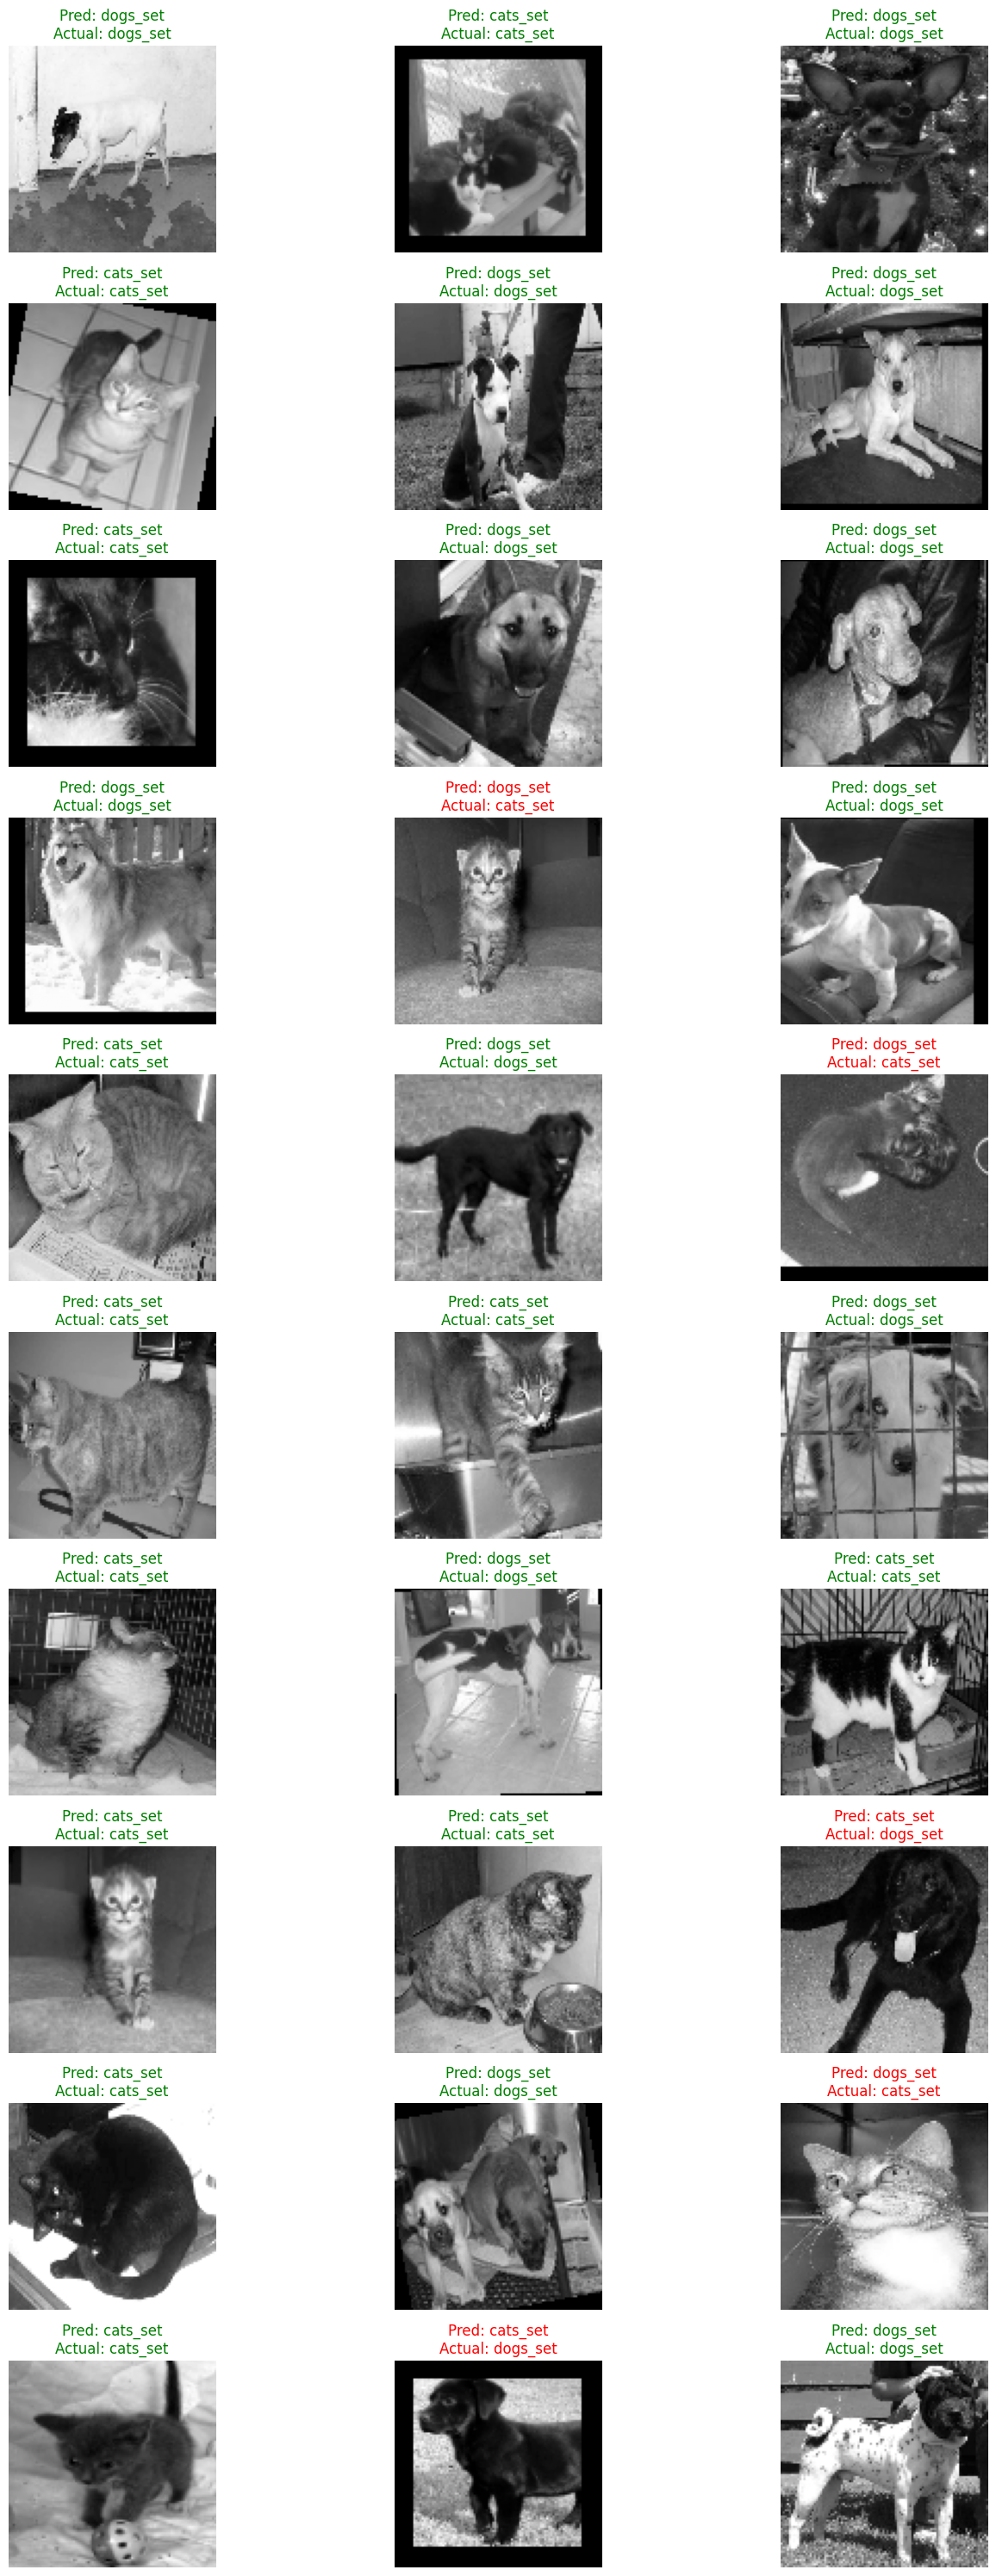

In [20]:
# Visualize predictions
L = 10
W = 3
fig, axes = plt.subplots(L, W, figsize=(15, 30))
axes = axes.ravel()

for i in np.arange(0, L * W):
    if i < len(x_test):
        axes[i].imshow(x_test[i].reshape(img_size, img_size), cmap='gray')

        # Get category names for display
        pred_category = list(label_dict.keys())[y_predicted_classes[i]]
        actual_category = list(label_dict.keys())[y_actual[i]]

        # Color code: green for correct, red for incorrect
        color = 'green' if y_predicted_classes[i] == y_actual[i] else 'red'

        axes[i].set_title(f"Pred: {pred_category}\nActual: {actual_category}", color=color)
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

    cats_set       0.79      0.82      0.80        80
    dogs_set       0.85      0.81      0.83        95

    accuracy                           0.82       175
   macro avg       0.82      0.82      0.82       175
weighted avg       0.82      0.82      0.82       175



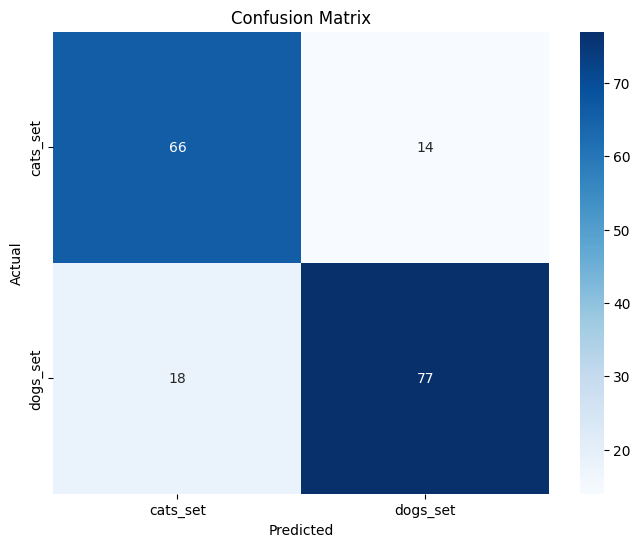


=== FINAL SUMMARY ===
Total training samples (with augmentation): 1575
Test accuracy: 0.8171
Data augmentation helped increase training samples by 1250 images


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(y_actual, y_predicted_classes, target_names=categories))

# Confusion matrix
cm = confusion_matrix(y_actual, y_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\n=== FINAL SUMMARY ===")
print(f"Total training samples (with augmentation): {len(x_train)}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Data augmentation helped increase training samples by {len(augmented_data)} images")